In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# 1. Import the Data

In [2]:
trans = pd.read_csv("product_category_name_translation.csv")
oo = pd.read_csv("olist_orders_dataset.csv")
ooi = pd.read_csv("olist_order_items_dataset.csv")
oop = pd.read_csv("olist_order_payments_dataset.csv")
oor = pd.read_csv("olist_order_reviews_dataset.csv")
oc = pd.read_csv("olist_customers_dataset.csv")
og = pd.read_csv("olist_geolocation_dataset.csv")
op = pd.read_csv("olist_products_dataset.csv")
os = pd.read_csv("olist_sellers_dataset.csv")

# 2. Clean the Data

## 2.1. Order Data

In [3]:
oo.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [4]:
oo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


### 2.1.1. Convert all columns to suitable type

In [5]:
oo['order_purchase_timestamp']= oo['order_purchase_timestamp'].astype('datetime64[ns]')
oo['order_approved_at'] = oo['order_approved_at'].astype('datetime64[ns]')
oo['order_delivered_carrier_date'] = oo['order_delivered_carrier_date'].astype('datetime64[ns]')
oo['order_delivered_customer_date'] = oo['order_delivered_customer_date'].astype('datetime64[ns]')
oo['order_estimated_delivery_date'] = oo['order_estimated_delivery_date'].astype('datetime64[ns]')

### 2.1.2. Check for Null Value

In [6]:
oo.isnull().sum()                                  

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

##### There are 3 columns with missing values, all in datetime type, so I decided to fill them with the value from their above row. However, to ensure that the filled date is not less than the date appearing in the previous column (order_delivered_carrier_date < order_approved_at, for instance), I set the condition that if the filled date is lower, it will be filled with the data from the left column and plus 1 day

In [7]:
oo['order_approved_at'] = oo['order_approved_at'].ffill()
oo['order_approved_at'] = np.where(oo['order_approved_at'] < oo['order_purchase_timestamp'],
                                oo['order_purchase_timestamp'] + pd.DateOffset(days=1),
                                oo['order_approved_at'] + pd.DateOffset(days=0))

oo['order_delivered_carrier_date'] = oo['order_delivered_carrier_date'].ffill()
oo['order_delivered_carrier_date'] = np.where(oo['order_delivered_carrier_date'] < oo['order_approved_at'],
                                oo['order_approved_at'] + pd.DateOffset(days=1),
                                oo['order_delivered_carrier_date'] + pd.DateOffset(days=0))

oo['order_delivered_customer_date'] = oo['order_delivered_customer_date'].ffill()
oo['order_delivered_customer_date'] = np.where(oo['order_delivered_customer_date'] < oo['order_delivered_carrier_date'],
                                oo['order_delivered_carrier_date'] + pd.DateOffset(days=1),
                                oo['order_delivered_customer_date'] + pd.DateOffset(days=0))

### 2.1.3. Check for Duplicated Value

In [8]:
oo.duplicated().sum()

0

### 2.1.4. Check if there is any mispell word in 'order_status' column

In [9]:
oo['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

## 2.2. Oder Items Data

In [10]:
ooi.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [11]:
ooi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


##### So there is no null value at all

### 2.2.1. Check for Duplicated Value

In [12]:
ooi.duplicated().sum()

0

### 2.2.2. Convert all columns to suitable type

In [13]:
ooi['shipping_limit_date'] = ooi['shipping_limit_date'].astype('datetime64[ns]')

## 2.3. Order Reviews Data

In [14]:
oor.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


oor.info()

### 2.3.1. Check for Null value

In [15]:
oor.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [16]:
oor = oor.drop (["review_comment_title", "review_comment_message"], axis = 1)

### 2.3.2. Check for Duplicated Value

In [17]:
oor.duplicated().sum()

0

### 2.3.3. Convert all columns to suitable type

In [18]:
oor['review_creation_date']= oor['review_creation_date'].astype('datetime64[ns]')
oor['review_answer_timestamp']= oor['review_answer_timestamp'].astype('datetime64[ns]')

## 2.4. Order Payment Data

In [19]:
oop.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [20]:
oop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


### 2.4.1. Check for Duplicated Value

In [21]:
oop.duplicated().sum()

0

### 2.4.2. Check if there is any mispell word in 'payment_type' column

In [22]:
oop['payment_type'] = oop['payment_type'].str.replace('_',' ')
oop['payment_type'] = oop['payment_type'].str.title()
oop['payment_type'].unique()

array(['Credit Card', 'Boleto', 'Voucher', 'Debit Card', 'Not Defined'],
      dtype=object)

## 2.5. Geolocation Data

In [23]:
og.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [24]:
og.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


##### From the Info, there is no Null Value

### 2.5.1. Check for Duplicated Value

In [25]:
og.duplicated().sum()

261831

In [26]:
og[og.duplicated()]

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
15,1046,-23.546081,-46.644820,sao paulo,SP
44,1046,-23.546081,-46.644820,sao paulo,SP
65,1046,-23.546081,-46.644820,sao paulo,SP
66,1009,-23.546935,-46.636588,sao paulo,SP
67,1046,-23.546081,-46.644820,sao paulo,SP
...,...,...,...,...,...
1000153,99970,-28.343273,-51.873734,ciriaco,RS
1000154,99950,-28.070493,-52.011342,tapejara,RS
1000159,99900,-27.877125,-52.224882,getulio vargas,RS
1000160,99950,-28.071855,-52.014716,tapejara,RS


In [27]:
og = og.drop_duplicates()

In [28]:
og.shape

(738332, 5)

##### The number of row reduce from over 1.000.000 at the begining to 738.332 now

### 2.5.2. Check if there is any mispell word in 'geolocation_city' column

In [29]:
og['geolocation_city'].unique()

array(['sao paulo', 'são paulo', 'sao bernardo do campo', ..., 'ciríaco',
       'estação', 'vila lângaro'], dtype=object)

In [30]:
og['geolocation_city'].nunique()

8011

##### It can be clearly seen that the data has some special characters and mispelled words, and there are over 8.000 different cities in the data

In [31]:
from unidecode import unidecode
og.loc[:,'geolocation_city'] = og['geolocation_city'].apply(lambda x: unidecode(x))                  # Transform local writing into international one(from 'são' to 'sao') 
og.loc[:,'geolocation_city'] = og['geolocation_city'].apply(lambda x: re.sub(r'[^\w\s]', '', x))     # Remove special character like $, %
og.loc[:,'geolocation_city'] = og['geolocation_city'].str.replace(' ','')                            # Remove spacing
og.loc[:,'geolocation_city'] = og['geolocation_city'].str.lower()                                    # Lower Case all the data
og.loc[:,'code'] = og['geolocation_city'] + og['geolocation_state']                                  # Cuz states may have similar city name, so i create a code include city name and state
og['geolocation_city'].nunique()

5901

##### After some adjustment, he number of unique city reduce from over 8.001 to 5.901. What I need to do now is to 
##### - Find the standard version of these city name
##### - Find the state name for each state code
##### To have the city name, I've found a data of standard city name of Brazil on Kaggle. Cuz there are many state that have the same city name, so i create a column named 'code', which is the combination of city name and state. I also do so to the table on Kaggle, so that i can latter merge these 2 tables and get the right name for each code matched

In [32]:
br = pd.read_csv("BRAZIL_CITIES_REV2022.csv")
br = br.iloc[:, [0,1]]

br['city'] = br['CITY'].apply(lambda x: unidecode(x))
br['city'] = br['city'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
br['city'] = br['city'].str.replace(' ','')
br['city'] = br['city'].str.lower()
br = br.drop_duplicates()
br['code'] = br['city'] + br['STATE']
br.head()

,CITY,STATE,city,code
0,Abadia De Goiás,GO,abadiadegoias,abadiadegoiasGO
1,Abadia Dos Dourados,MG,abadiadosdourados,abadiadosdouradosMG
2,Abadiânia,GO,abadiania,abadianiaGO
3,Abaetetuba,PA,abaetetuba,abaetetubaPA
4,Abaeté,MG,abaete,abaeteMG


##### After Having the right city name, I also found a table from wiki that contain state code and state name as well

In [33]:
url = "https://en.wikipedia.org/wiki/ISO_3166-2:BR" 

tables = pd.read_html(url)

print(f"Number of tables found: {len(tables)}")
state_code = tables[0] 
state_code = state_code.iloc[:, [0,1]]
state_code.loc[:,'Code'] = state_code['Code'].str[-2:]
state_code.head()

Number of tables found: 4


,Code,Subdivision name (pt)
0,AC,Acre
1,AL,Alagoas
2,AP,Amapá
3,AM,Amazonas
4,BA,Bahia


In [34]:
og = pd.merge(og, br[['code','CITY']], on='code', how='left')
og.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,code,CITY
0,1037,-23.545621,-46.639292,saopaulo,SP,saopauloSP,São Paulo
1,1046,-23.546081,-46.644820,saopaulo,SP,saopauloSP,São Paulo
2,1046,-23.546129,-46.642951,saopaulo,SP,saopauloSP,São Paulo
3,1041,-23.544392,-46.639499,saopaulo,SP,saopauloSP,São Paulo
4,1035,-23.541578,-46.641607,saopaulo,SP,saopauloSP,São Paulo


In [35]:
og.isnull().sum()

geolocation_zip_code_prefix       0
geolocation_lat                   0
geolocation_lng                   0
geolocation_city                  0
geolocation_state                 0
code                              0
CITY                           3999
dtype: int64

##### After merging, most of the data found their right city name. However, there are still 3.999 out of 738.332 haven't found their right name. Also mean only 0.541% of the data is not correct, but this number is too minor so I gonna handle it if I have free time

In [685]:
null = og[og['CITY'].isnull()]
null['code'].value_counts().reset_index().head(10)

,code,count
0,embuSP,285
1,paratiRJ,153
2,piumhiiMG,98
3,barradesaojoaoRJ,71
4,bonfimpaulistaSP,69
5,cachoeiradocampoMG,62
6,arraialdajudaBA,61
7,taguatingaDF,59
8,papucaiaRJ,53
9,bomjesusGO,53


In [516]:
br[br['city'].str.contains('tagua')]

,CITY,STATE,city,code
524,Bataguassu,MS,bataguassu,bataguassuMS
1132,Cataguases,MG,cataguases,cataguasesMG
2271,Itaguajé,PR,itaguaje,itaguajePR
2272,Itaguara,MG,itaguara,itaguaraMG
2273,Itaguari,GO,itaguari,itaguariGO
2274,Itaguaru,GO,itaguaru,itaguaruGO
2275,Itaguatins,TO,itaguatins,itaguatinsTO
2276,Itaguaçu,ES,itaguacu,itaguacuES
2277,Itaguaçu Da Bahia,BA,itaguacudabahia,itaguacudabahiaBA
2278,Itaguaí,RJ,itaguai,itaguaiRJ


In [ ]:
for i, data in og['code'].items():
    if data == 'embuSP':
        og.loc[i, 'code'] = 'embudasartesSP'         # Embu is a short-hand version of embudasartes
    if data == 'paratiRJ':
        og.loc[i, 'code'] = 'paratyRJ'               # Just a mispelled
    if data == 'piumhiiMG':
        og.loc[i, 'code'] = 'piumhiMG'               # Just a mispelled
    if data == 'barradesaojoaoRJ':
        og.loc[i, 'code'] = 'saojoaodabarraRJ'       # It is written backwards
    if data == 'bonfimpaulistaSP':
        og.loc[i, 'code'] = 'ribeiraopretoSP'        # It a district of Ribeirão Preto
    if data == 'cachoeiradocampoMG':
        og.loc[i, 'code'] = 'ouropretoMG'            # It a district of Ouro Preto
    if data == 'arraialdajudaBA':
        og.loc[i, 'code'] = 'portoseguroBA'          # It a district of Porto Seguro
         

##### Now I just need to replace the messy city name and coded state with their right name

In [36]:
og = pd.merge(og, state_code, left_on='geolocation_state', right_on='Code', how='left')
og.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,code,CITY,Code,Subdivision name (pt)
0,1037,-23.545621,-46.639292,saopaulo,SP,saopauloSP,São Paulo,SP,São Paulo
1,1046,-23.546081,-46.644820,saopaulo,SP,saopauloSP,São Paulo,SP,São Paulo
2,1046,-23.546129,-46.642951,saopaulo,SP,saopauloSP,São Paulo,SP,São Paulo
3,1041,-23.544392,-46.639499,saopaulo,SP,saopauloSP,São Paulo,SP,São Paulo
4,1035,-23.541578,-46.641607,saopaulo,SP,saopauloSP,São Paulo,SP,São Paulo


In [37]:
og = og.drop(['geolocation_city', 'geolocation_state', 'code', 'Code'], axis = 1)
og = og.rename(columns = {'Subdivision name (pt)' : 'state','CITY' : 'city'})
og.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,city,state
0,1037,-23.545621,-46.639292,São Paulo,São Paulo
1,1046,-23.546081,-46.644820,São Paulo,São Paulo
2,1046,-23.546129,-46.642951,São Paulo,São Paulo
3,1041,-23.544392,-46.639499,São Paulo,São Paulo
4,1035,-23.541578,-46.641607,São Paulo,São Paulo


In [38]:
og['city'] = og['city'].fillna('Other')

In [39]:
og.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738332 entries, 0 to 738331
Data columns (total 5 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   geolocation_zip_code_prefix  738332 non-null  int64  
 1   geolocation_lat              738332 non-null  float64
 2   geolocation_lng              738332 non-null  float64
 3   city                         738332 non-null  object 
 4   state                        738332 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 28.2+ MB


### 5.3. Convert all columns to suitable type

In [40]:
og[og['geolocation_zip_code_prefix'] == 99965]

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,city,state
737985,99965,-28.173892,-52.038447,Água Santa,Rio Grande do Sul
737986,99965,-28.178429,-52.035260,Água Santa,Rio Grande do Sul
738148,99965,-28.210845,-52.059927,Água Santa,Rio Grande do Sul
738163,99965,-28.181715,-52.035593,Água Santa,Rio Grande do Sul
738260,99965,-28.174697,-52.035508,Água Santa,Rio Grande do Sul
738327,99965,-28.180655,-52.034367,Água Santa,Rio Grande do Sul


In [41]:
og['geolocation_zip_code_prefix'].nunique()

19015

In [42]:
ogg = og.drop_duplicates(subset=['geolocation_zip_code_prefix'])
ogg.shape

(19015, 5)

In [195]:
ogg.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,city,state
0,1037,-23.545621,-46.639292,São Paulo,São Paulo
1,1046,-23.546081,-46.644820,São Paulo,São Paulo
3,1041,-23.544392,-46.639499,São Paulo,São Paulo
4,1035,-23.541578,-46.641607,São Paulo,São Paulo
5,1012,-23.547762,-46.635361,São Paulo,São Paulo


## 2.6. Customer Data

In [43]:
oc.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [44]:
oc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


### 2.6.1. Check for Duplicated Value

In [45]:
oc.duplicated().sum()

0

### 2.6.2. Fix City and State

##### Cuz I already fix the City and State name before in og, so I just simply replace the data in this customer table based on the 'customer_zip_code_prefix'

In [46]:
oc = pd.merge(oc, ogg[['city','state','geolocation_zip_code_prefix']], left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')

In [47]:
oc.isnull().sum()

customer_id                      0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
city                           278
state                          278
geolocation_zip_code_prefix    278
dtype: int64

##### Once again, after merging, most of the data found their right city name. However, there are still 278 out of 99.441 haven't found their right name. Also mean only 0.279% of the data is not correct, but this number is too minor so I just simply fill those missing rows with 'Other'

In [48]:
oc = oc.drop(['customer_city', 'customer_state', 'geolocation_zip_code_prefix'], axis = 1)
oc['city'] = oc['city'].fillna('Other')
oc['state'] = oc['state'].fillna('Other')

## 2.7. Product Data

In [49]:
op.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [50]:
op.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


## 2.7.1. Check for Null Value

In [51]:
op.isnull().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [52]:
op[op['product_category_name'].isnull()].head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
105,a41e356c76fab66334f36de622ecbd3a,NaN,NaN,NaN,NaN,650.0,17.0,14.0,12.0
128,d8dee61c2034d6d075997acef1870e9b,NaN,NaN,NaN,NaN,300.0,16.0,7.0,20.0
145,56139431d72cd51f19eb9f7dae4d1617,NaN,NaN,NaN,NaN,200.0,20.0,20.0,20.0
154,46b48281eb6d663ced748f324108c733,NaN,NaN,NaN,NaN,18500.0,41.0,30.0,41.0
197,5fb61f482620cb672f5e586bb132eae9,NaN,NaN,NaN,NaN,300.0,35.0,7.0,12.0


In [53]:
op['product_category_name'] = op['product_category_name'].fillna('Not Given')
op['product_name_lenght'] = op['product_name_lenght'].fillna('Not Given')
op['product_description_lenght'] = op['product_description_lenght'].fillna('Not Given')
op['product_photos_qty'] = op['product_photos_qty'].fillna('Not Given')
op = op.dropna()

## 2.7.2. Check for Duplicated Value

In [54]:
op.duplicated().sum()

0

In [55]:
op.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32949 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32949 non-null  object 
 1   product_category_name       32949 non-null  object 
 2   product_name_lenght         32949 non-null  object 
 3   product_description_lenght  32949 non-null  object 
 4   product_photos_qty          32949 non-null  object 
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(4), object(5)
memory usage: 2.5+ MB


## 2.7.3. Turn product categoty name to english

In [56]:
op = op.merge(trans, on='product_category_name', how='outer')
op.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32949 entries, 0 to 32948
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     32949 non-null  object 
 1   product_category_name          32949 non-null  object 
 2   product_name_lenght            32949 non-null  object 
 3   product_description_lenght     32949 non-null  object 
 4   product_photos_qty             32949 non-null  object 
 5   product_weight_g               32949 non-null  float64
 6   product_length_cm              32949 non-null  float64
 7   product_height_cm              32949 non-null  float64
 8   product_width_cm               32949 non-null  float64
 9   product_category_name_english  32327 non-null  object 
dtypes: float64(4), object(6)
memory usage: 2.5+ MB


In [57]:
op['product_category_name_english'] = op['product_category_name_english'].fillna(op['product_category_name'])
op = op.drop('product_category_name', axis=1)

op['product_category_name_english'] = op['product_category_name_english'].str.replace('_', ' ')
op['product_category_name_english'] = op['product_category_name_english'].str.title()
op.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32949 entries, 0 to 32948
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     32949 non-null  object 
 1   product_name_lenght            32949 non-null  object 
 2   product_description_lenght     32949 non-null  object 
 3   product_photos_qty             32949 non-null  object 
 4   product_weight_g               32949 non-null  float64
 5   product_length_cm              32949 non-null  float64
 6   product_height_cm              32949 non-null  float64
 7   product_width_cm               32949 non-null  float64
 8   product_category_name_english  32949 non-null  object 
dtypes: float64(4), object(5)
memory usage: 2.3+ MB


## 2.8. Seller Data

In [58]:
os.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [59]:
os.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


## 2.8.1. Check for Duplicated Value

In [60]:
os.duplicated().sum()

0

## 2.8.2. Fix City and State

In [61]:
os = pd.merge(os, ogg[['city','state','geolocation_zip_code_prefix']], left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')

In [62]:
os.isnull().sum()

seller_id                      0
seller_zip_code_prefix         0
seller_city                    0
seller_state                   0
city                           7
state                          7
geolocation_zip_code_prefix    7
dtype: int64

In [63]:
os = os.drop(['seller_city', 'seller_state', 'geolocation_zip_code_prefix'], axis = 1)
os['city'] = os['city'].fillna('Other')
os['state'] = os['state'].fillna('Other')

## 2.9. Save for later use in Power BI

In [64]:
oo.to_csv('D:\Porfolio\Project 2 - E-Commerce - Olist\Cleaned Data\Orders.csv', index=False)
ooi.to_csv('D:\Porfolio\Project 2 - E-Commerce - Olist\Cleaned Data\Order Item.csv', index=False)
oop.to_csv('D:\Porfolio\Project 2 - E-Commerce - Olist\Cleaned Data\Order Payment.csv', index=False)
oor.to_csv('D:\Porfolio\Project 2 - E-Commerce - Olist\Cleaned Data\Order Review.csv', index=False)
oc.to_csv('D:\Porfolio\Project 2 - E-Commerce - Olist\Cleaned Data\Customer.csv', index=False)
og.to_csv('D:\Porfolio\Project 2 - E-Commerce - Olist\Cleaned Data\Geolocation.csv', index=False)
op.to_csv('D:\Porfolio\Project 2 - E-Commerce - Olist\Cleaned Data\Product.csv', index=False)
os.to_csv('D:\Porfolio\Project 2 - E-Commerce - Olist\Cleaned Data\Seller.csv', index=False)

In [186]:
oo_oop = pd.merge(oo, oop, on='order_id', how='left')

ooi_op = pd.merge(ooi, op, on='product_id', how='left')
oo_ooi_op = pd.merge(oo, ooi_op, on='order_id', how='left')

oo_oc = pd.merge(oo, oc, on='customer_id', how='left')
oo_oc_oop = pd.merge(oo_oc, oop, on='order_id', how='left')
oo_oc_ogg = pd.merge(oo_oc, ogg, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')

op_ooi = pd.merge(op, ooi, on='product_id', how='left')
op_ooi_os = pd.merge(op_ooi, os, on='seller_id', how='left')
op_ooi_oor = pd.merge(op_ooi, oor, on='order_id', how='left')



# 3. Overview Analyse

In [ ]:
##### What are the States with highest Revenue
##### What are the States with highest Number of Order
##### What are the Cities with highest Revenue
##### Which City has most Seller

##### What is the Most-ordered Category
##### What is the Category with Highest Review Score

##### What is the most use Payment Method

## 3.1. KPIs

### 3.1.1 Total Order

In [66]:
total_order = oo['order_id'].count()
total_order

99441

### 3.1.2. Unique Customer

In [67]:
unique_customer = oo['customer_id'].nunique()
unique_customer

99441

### 3.1.3 Average Approval Time

In [68]:
oo['approval_time_seconds'] = (oo["order_approved_at"] - oo["order_purchase_timestamp"]).dt.total_seconds()
avg_approval_time_difference = (oo["order_approved_at"] - oo["order_purchase_timestamp"]).mean()

approval_time_total_seconds = avg_approval_time_difference.total_seconds()
approval_time_hours = int(approval_time_total_seconds // 3600)
approval_time_minutes = int((approval_time_total_seconds % 3600) // 60)
approval_time_seconds = int(approval_time_total_seconds % 60)
avg_approval_time = f"{approval_time_hours}h - {approval_time_minutes}m - {approval_time_seconds}s"
avg_approval_time

'15h - 13m - 57s'

### 3.1.4. Average Delivery Time

In [69]:
oo['delivery_time_seconds'] = (oo['order_delivered_customer_date'] - oo['order_delivered_carrier_date']).dt.total_seconds()
avg_deliver_time_difference = (oo['order_delivered_customer_date'] - oo['order_delivered_carrier_date']).mean()

deliver_time_total_seconds = avg_deliver_time_difference.total_seconds()
deliver_time_days = int(deliver_time_total_seconds // 86400)
deliver_time_hours = int((deliver_time_total_seconds % 86400) // 3600)
deliver_time_minutes = int((deliver_time_total_seconds % 3600) // 60)
deliver_time_seconds = int(deliver_time_total_seconds % 60)

avg_deliver_time = f"{deliver_time_days}d - {deliver_time_hours}h - {deliver_time_minutes}m - {deliver_time_seconds}s"
avg_deliver_time

'10d - 8h - 44m - 20s'

### 3.1.5. Total Item Ordered

In [70]:
total_item_ordered = ooi['order_item_id'].count()
total_item_ordered

112650

### 3.1.6. Total Revenue

In [71]:
total_revenue = oop['payment_value'].sum()
total_revenue

16008872.12

### 3.1.7. Average Review Score

In [72]:
average_review_score = oor['review_score'].mean().round(2)
average_review_score

4.09

### 3.1.8. Unique Seller

In [73]:
unique_seller = os['seller_id'].nunique()
unique_seller

3095

### 3.1.9. Average Value per Order

In [74]:
average_value_per_order = (total_revenue/total_order).round(2)
average_value_per_order

160.99

### 3.1.10. On-Time Delivery Rate

In [75]:
oo['Delivery Duration'] = (oo['order_estimated_delivery_date'] - oo['order_delivered_customer_date']).dt.total_seconds()
late = oo[oo['Delivery Duration'] < 0].shape[0]
on_time_delivery_rate = (100 - (late * 100 / total_order)).round(2)
on_time_delivery_rate = f"{on_time_delivery_rate}%"
on_time_delivery_rate

'90.47%'

## 3.2. Charts

### 3.2.1. Revenue by Time

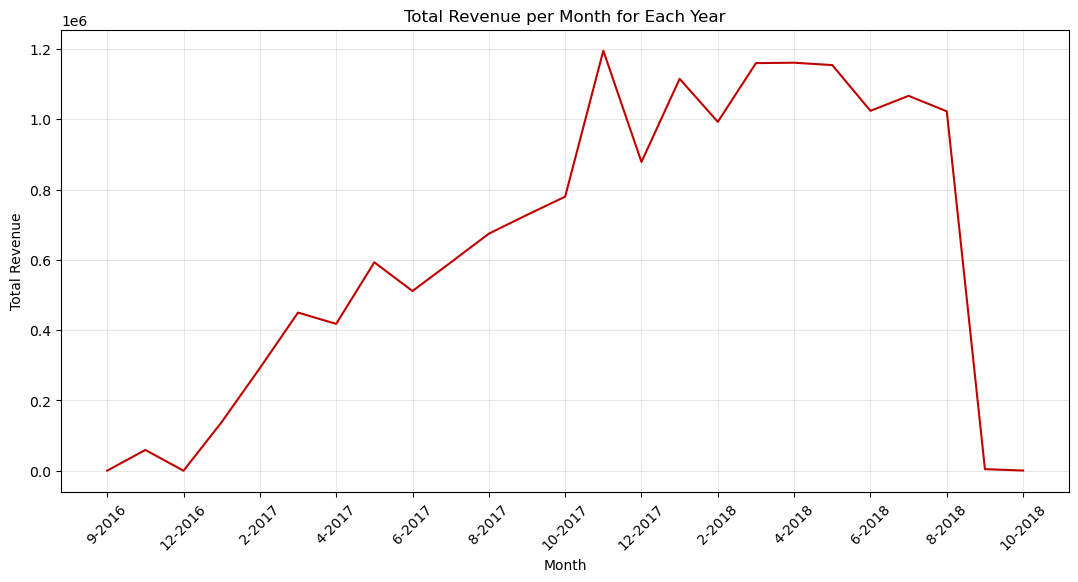

In [76]:
revenue_by_time = oo_oop[['order_purchase_timestamp','payment_value']].copy()
revenue_by_time['Year'] = revenue_by_time['order_purchase_timestamp'].dt.year
revenue_by_time['Month'] = revenue_by_time['order_purchase_timestamp'].dt.month

revenue_by_time = revenue_by_time.groupby(['Year','Month'])['payment_value'].sum().reset_index(name='Total Revenue')
revenue_by_time['Month-Year'] = revenue_by_time['Month'].astype(str) + '-' + revenue_by_time['Year'].astype(str)

plt.figure(figsize=(13, 6))
plt.plot(revenue_by_time['Month-Year'], revenue_by_time['Total Revenue'], color = "#C00000")
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.title('Total Revenue per Month for Each Year')
plt.grid(True, alpha = 0.3)
plt.xticks(revenue_by_time.index[::2], revenue_by_time['Month-Year'][::2], rotation=45)
plt.show()

In [77]:
oo_oop[oo_oop['order_purchase_timestamp'] > '2018-09-01'].head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value
1876,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,2018-09-21 13:54:16,2018-09-22 13:54:16,2018-09-23 13:54:16,2018-10-17,1.0,Voucher,1.0,191.46
5353,ea844c92cf978ea23321fa7fe5871761,6ddc45ad08e6a2c885ca2255fc52d6df,canceled,2018-09-13 09:56:12,2018-09-14 09:56:12,2018-09-15 09:56:12,2018-09-16 09:56:12,2018-09-27,1.0,Voucher,1.0,414.04
10427,87ae60ef8b08ae0e5f903cacb53a6904,fea4d57ed3a45455f89c25ef3dae8ee8,canceled,2018-09-11 16:45:54,2018-09-12 16:45:54,2018-09-13 16:45:54,2018-09-14 16:45:54,2018-09-26,1.0,Voucher,1.0,258.67
17051,bd35b677fd239386e9861d11ae98ab56,ad2eb5d02c0808bcd8743117f6383cf6,canceled,2018-09-17 17:21:16,2018-09-18 17:21:16,2018-09-19 17:21:16,2018-09-20 17:21:16,2018-10-01,1.0,Voucher,1.0,84.58
21686,4d59cc2a2e7bb6c0a851725f5888a9b5,ead83a4f8f7be8c3034b2e98754a6147,canceled,2018-09-06 14:50:07,2018-09-07 14:50:07,2018-09-08 14:50:07,2018-09-09 14:50:07,2018-09-21,1.0,Voucher,1.0,69.46


### 3.2.2. Number of Order by Time

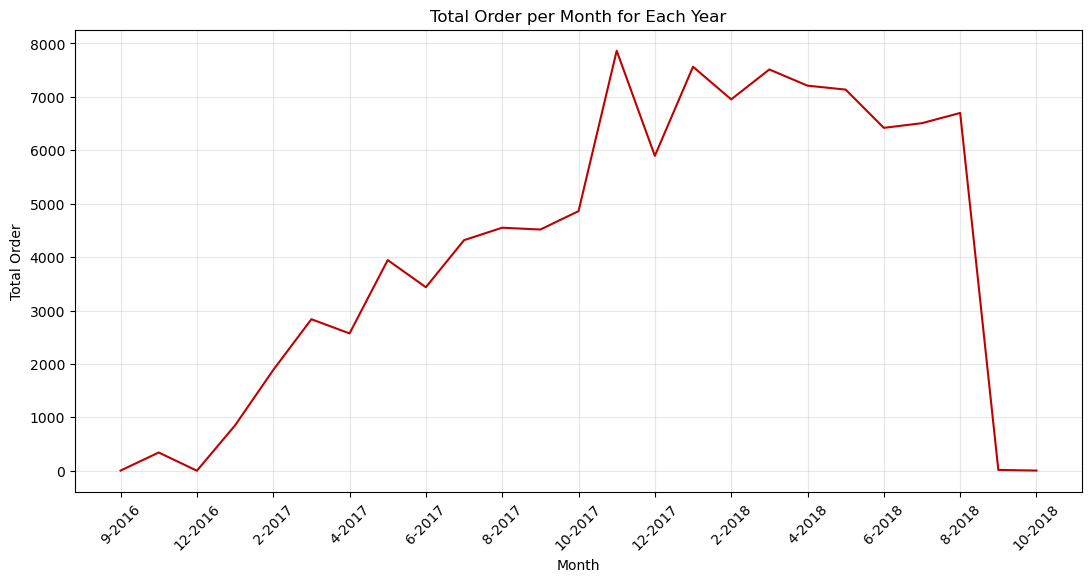

In [82]:
order_by_time = oo_oop[['order_purchase_timestamp','order_id']].copy()
order_by_time['Year'] = order_by_time['order_purchase_timestamp'].dt.year
order_by_time['Month'] = order_by_time['order_purchase_timestamp'].dt.month

order_by_time = order_by_time.groupby(['Year','Month'])['order_id'].count().reset_index(name='Total Order')
order_by_time['Month-Year'] = order_by_time['Month'].astype(str) + '-' + order_by_time['Year'].astype(str)

plt.figure(figsize=(13, 6))
plt.plot(order_by_time['Month-Year'], order_by_time['Total Order'], color = "#C00000")
plt.xlabel('Month')
plt.ylabel('Total Order')
plt.title('Total Order per Month for Each Year')
plt.grid(True, alpha = 0.3)
plt.xticks(order_by_time.index[::2], order_by_time['Month-Year'][::2], rotation=45)
plt.show()

### Order Status Distribution

In [86]:
order_status_dstribution = oo['order_status'].value_counts().reset_index()
order_status_dstribution

,order_status,count
0,delivered,96478
1,shipped,1107
2,canceled,625
3,unavailable,609
4,invoiced,314
5,processing,301
6,created,5
7,approved,2


### Payment Type Distribution

In [92]:
payment_type_distribution = oop['payment_type'].value_counts().reset_index()
payment_type_distribution

,payment_type,count
0,Credit Card,76795
1,Boleto,19784
2,Voucher,5775
3,Debit Card,1529
4,Not Defined,3


### Review Score Distribution

In [94]:
review_score_distribution = oor['review_score'].value_counts().reset_index()
review_score_distribution

,review_score,count
0,5,57328
1,4,19142
2,1,11424
3,3,8179
4,2,3151


In [97]:
ooi.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


### Most Order Product 

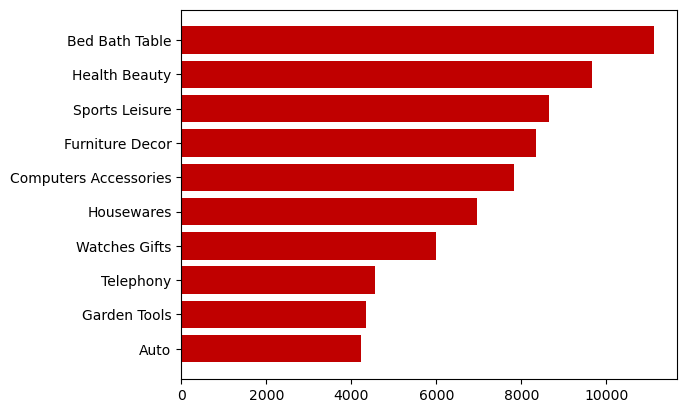

In [107]:
most_ordered_category = oo_ooi_op['product_category_name_english'].value_counts().head(10).reset_index()

plt.barh(most_ordered_category['product_category_name_english'],most_ordered_category['count'], color = "#C00000")
plt.gca().invert_yaxis() 
plt.show()

### Revenue by State

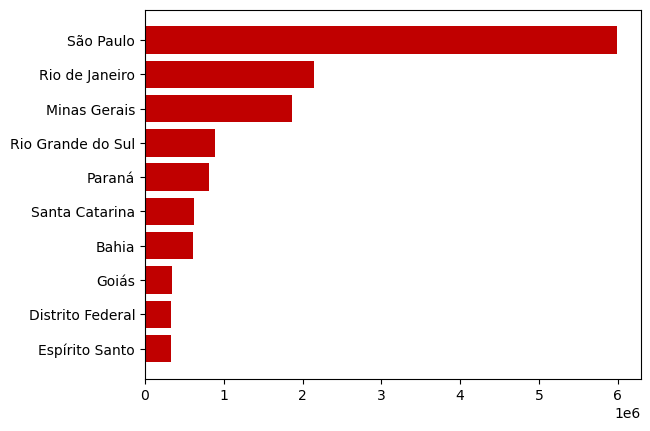

In [190]:
revenue_by_state = oo_oc_oop.groupby('state')['payment_value'].sum().reset_index().sort_values(by='payment_value', ascending = False)
top_revenue_by_state = revenue_by_state.head(10)
plt.barh(top_revenue_by_state['state'],top_revenue_by_state['payment_value'], color = "#C00000")
plt.gca().invert_yaxis() 
plt.show()

### Order by State

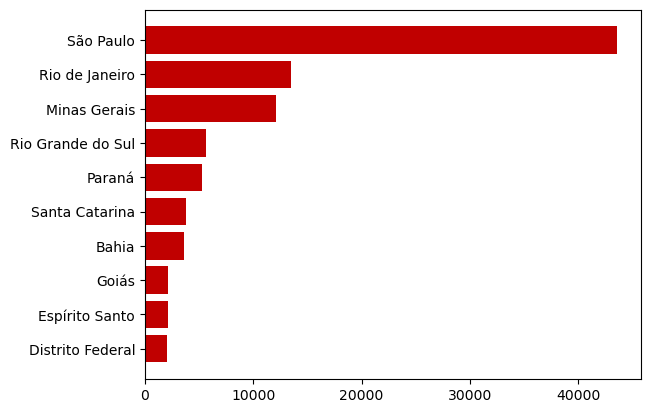

In [131]:
order_by_state = oo_oc_oop.groupby('state')['order_id'].count().reset_index().sort_values(by='order_id', ascending = False).head(10)

plt.barh(order_by_state['state'],order_by_state['order_id'], color = "#C00000")
plt.gca().invert_yaxis() 
plt.show()

### City with most Seller

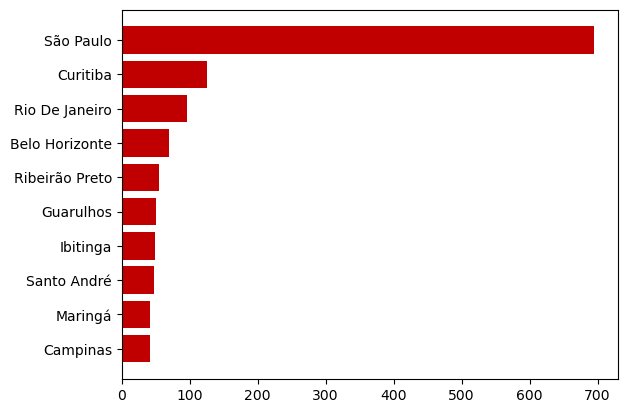

In [155]:
city_with_most_seller = os['city'].value_counts().head(10).reset_index().sort_values(by='count', ascending = False).head(10)
plt.barh(city_with_most_seller['city'],city_with_most_seller['count'], color = "#C00000")
plt.gca().invert_yaxis() 
plt.show()

### Revenue by Day in Week

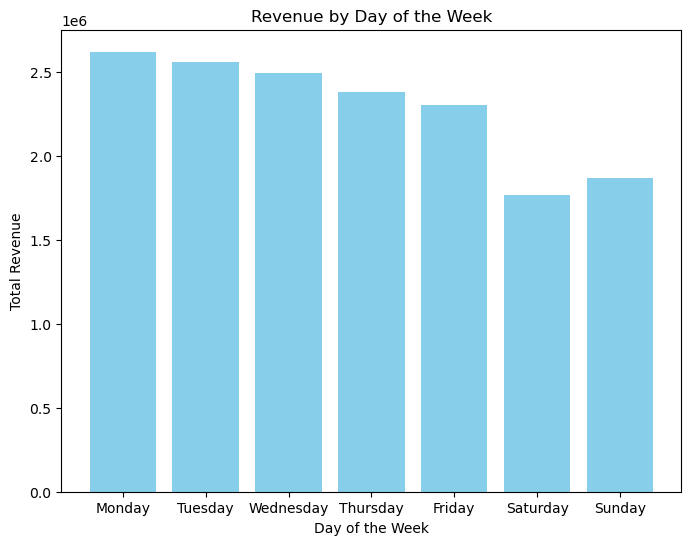

In [138]:
revenue_per_day = oo_oop[['order_purchase_timestamp','payment_value']].copy()
revenue_per_day['Day_of_Week'] = revenue_per_day['order_purchase_timestamp'].dt.day_name()

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
revenue_per_day['Day_of_Week'] = pd.Categorical(revenue_per_day['Day_of_Week'], categories=days_order, ordered=True)

revenue_per_day = revenue_per_day.groupby('Day_of_Week', observed=False)['payment_value'].sum()

plt.figure(figsize=(8, 6))
plt.bar(revenue_per_day.index, revenue_per_day.values, color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Total Revenue')
plt.title('Revenue by Day of the Week')
plt.show()

### Number of Seller by Category

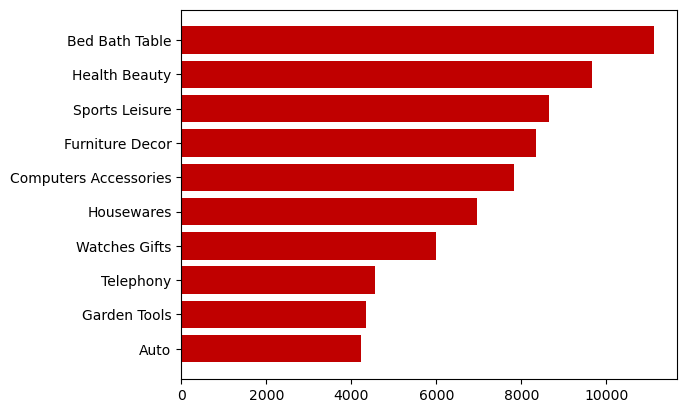

In [151]:
seller_by_category = op_ooi_os.groupby('product_category_name_english')['seller_id'].count().reset_index().sort_values(by='seller_id', ascending = False).head(10)

plt.barh(seller_by_category['product_category_name_english'],seller_by_category['seller_id'], color = "#C00000")
plt.gca().invert_yaxis() 
plt.show()

In [163]:
review_score_by_category = op_ooi_oor.groupby('product_category_name_english')['review_score'].mean().reset_index().sort_values(by='review_score', ascending = False)
review_score_by_category.head(10)

,product_category_name_english,review_score
11,Cds Dvds Musicals,4.642857
29,Fashion Childrens Clothes,4.500000
8,Books General Interest,4.446266
22,Costruction Tools Tools,4.444444
35,Flowers,4.419355
9,Books Imported,4.400000
10,Books Technical,4.368421
37,Food Drink,4.315412
53,Luggage Accessories,4.315257
67,Small Appliances Home Oven And Coffee,4.302632
